# 2D Isostatic gravity inversion - Inverse Problem

Este [IPython Notebook](http://ipython.org/videos.html#the-ipython-notebook) utiliza a biblioteca de código aberto [Fatiando a Terra](http://fatiando.org/)

In [1]:
%matplotlib inline
import numpy as np
from scipy.misc import derivative
import scipy as spy
from scipy import interpolate
import matplotlib
#matplotlib.use('TkAgg', force=True)
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import math
import cPickle as pickle
import datetime
import string as st

from scipy.misc import imread

from __future__ import division

from fatiando import gravmag, mesher, utils, gridder
from fatiando.mesher import Prism, Polygon
from fatiando.gravmag import prism
from fatiando.utils import ang2vec, si2nt, contaminate
from fatiando.gridder import regular
from fatiando.vis import mpl

from numpy.testing import assert_almost_equal
from numpy.testing import assert_array_almost_equal
from pytest import raises

plt.rc('font', size=16)

/Users/macelabastos/anaconda2/lib/python2.7/site-packages/fatiando/vis/mpl.py:76: UserWarning: This module will be removed in v0.6. We recommend the use of matplotlib.pyplot module directly. Some of the fatiando specific functions will remain.
  "specific functions will remain.")


In [2]:
import functions as fc

## Observation coordinates.

In [3]:
# Model`s limits
ymin = 0.0
ymax = 380000.0
zmin = -1000.0
zmax = 40000.0
xmin = -100000.0
xmax = 100000.0

area = [ymin, ymax, zmax, zmin]

In [4]:
ny = 150 # number of observation datas and number of prisms along the profile
# coordinates defining the horizontal boundaries of the
# adjacent columns along the profile
y = np.linspace(ymin, ymax, ny)

In [5]:
# coordinates of the center of the columns forming the
# interpretation model
n = ny - 1
dy = (ymax - ymin)/n
ycmin = ymin + 0.5*dy
ycmax = ymax - 0.5*dy
yc = np.reshape(np.linspace(ycmin, ycmax, n),(n,1))
x = np.zeros_like(yc)
z = np.zeros_like(yc)-150.0

In [6]:
## Edge extension (observation coordinates)
sigma = 2.0
edge = sigma*dy*n

## Model parameters

In [7]:
# Model densities
# Indices and polygons relationship:
# cc = continental crust layer
# oc = ocean crust layer
# w = water layer
# s = sediment layer
# m = mantle layer
dw = np.array([1030.0])
ds0 = np.array([2600.0])
ds1 = np.array([2600.0])
dcc = np.array([2850.0])
doc = np.array([2885.0])
dm = np.array([3250.0])
#dc = dcc
# coordinate defining the horizontal boundaries of the continent-ocean boundary
COT = 165000.0
# list defining crust density variance
dc = np.zeros_like(yc)
aux = yc <= COT
for i in range(len(yc[aux])):
    dc[i] = dcc
for i in range(len(yc[aux]),n):
    dc[i] = doc    
# defining sediments layers density matrix
ds = np.vstack((np.reshape(np.repeat(ds0,n),(1,n)),np.reshape(np.repeat(ds1,n),(1,n))))

# S0 => isostatic compensation surface (Airy's model)
S0 = np.array([48000.0]) #original

## Synthetic data

In [8]:
gsyn = np.reshape(np.loadtxt('../data/B-model-rifted-margin-synthetic-gravity-data.txt'),(n,1))

## Water bottom

In [9]:
bathymetry = np.reshape(np.loadtxt('../data/etopo1-pelotas.txt'),(n,1))
tw = 0.0 - bathymetry

## True surfaces

In [10]:
tos = np.reshape(np.loadtxt('../data/B-model-rifted-margin-true-tos-surface.txt'),(n,1))

true_basement = np.reshape(np.loadtxt('../data/B-model-rifted-margin-true-basement-surface.txt'),(n,1))

true_moho = np.reshape(np.loadtxt('../data/B-model-rifted-margin-true-moho-surface.txt'),(n,1))

# True reference moho surface (SR = S0+dS0)
true_S0 = np.array([48000.0])
true_dS0 = np.array([5000.0]) #original

In [11]:
# True first layer sediments thickness
ts0 = tos - tw
# True second layer sediments thickness
true_ts1 = true_basement - tos
# True thickness sediments vector
true_ts = np.vstack((np.reshape(ts0,(1,n)),np.reshape(true_ts1,(1,n))))
# True layer anti-root thickness
true_tm = S0 - true_moho
# true parameters vector
ptrue = np.vstack((true_ts1, true_tm, true_dS0))

## Initial guess surfaces

In [12]:
# initial guess basement surface
ini_basement = np.reshape(np.loadtxt('../data/B-model-rifted-margin-initial-basement-surface.txt'),(n,1))

# initial guess moho surface
ini_moho = np.reshape(np.loadtxt('../data/B-model-rifted-margin-initial-moho-surface.txt'),(n,1))

# initial guess reference moho surface (SR = S0+dS0)
ini_dS0 = np.array([7000.0])
ini_RM = S0 + ini_dS0

In [13]:
# initial guess layer igneous thickness
ini_ts1 = ini_basement - tos
# initial guess anti-root layer thickness
ini_tm = S0 - ini_moho
# initial guess parameters vector
p0 = np.vstack((ini_ts1, ini_tm, ini_dS0))

## Known depths

In [14]:
# Known values: basement and moho surfaces

base_known = np.loadtxt('../data/B-model-rifted-margin-basement-known-depths.txt')
#base_known = np.loadtxt('../data/B-model-rifted-margin-basement-more-known-depths.txt')
#base_known_new = np.loadtxt('../data/B-model-rifted-margin-basement-new-known-depths.txt')
#base_known_old = np.loadtxt('../data/B-model-rifted-margin-basement-known-depths.txt')

moho_known = np.loadtxt('../data/B-model-rifted-margin-moho-known-depths.txt')

In [15]:
(rs,index_rs) = fc.base_known_function(dy,tw,yc,base_known,ts0,two_layers=True)

In [16]:
(rm,index_rm) = fc.moho_known_function(dy,yc,S0,moho_known)

In [17]:
index_base = index_rs
index_moho = index_rm - n

assert_almost_equal(base_known[:,0], yc[index_base][:,0], decimal=6)

assert_almost_equal(moho_known[:,0], yc[index_moho][:,0], decimal=6)

assert_almost_equal(true_ts1[index_base][:,0], rs[:,0], decimal=6)

assert_almost_equal((true_tm[index_moho][:,0]), rm[:,0], decimal=6)

## Initial guess data

In [18]:
g0 = np.reshape(np.loadtxt('../data/B-model-rifted-margin-initial-guess-gravity-data.txt'),(n,1))

### parameters vector box limits

In [19]:
# true thickness vector limits
print 'ts =>', np.min(ptrue[0:n]),'-', np.max(ptrue[0:n])
print 'tm =>', np.min(ptrue[n:n+n]),'-', np.max(ptrue[n:n+n])
print 'dS0 =>', ptrue[n+n]

ts => 949.242289206 - 24700.8634131
tm => 42.5629505235 - 20954.3601479
dS0 => [ 5000.]


In [20]:
# initial guess thickness vector limits
print 'ts =>', np.min(p0[0:n]),'-', np.max(p0[0:n])
print 'tm =>', np.min(p0[n:n+n]),'-', np.max(p0[n:n+n])
print 'dS0 =>', p0[n+n]

ts => 4757.75211853 - 9466.43519237
tm => 5549.8553644 - 12653.0428752
dS0 => [ 7000.]


In [21]:
# defining parameters values limits
pjmin = np.zeros((len(ptrue),1))
pjmax = np.zeros((len(ptrue),1))
pjmin[0:n] = 0.0
pjmax[0:n] = 27000.
pjmin[n:n+n] = 0.0
pjmax[n:n+n] = 26000.
pjmin[n+n] = 0.0
pjmax[n+n] = 12000.

### Inversion code

In [22]:
#Parametros internos para implementacao da funcao (convergencia, numero de iteracoes, etc.)
beta = 10**(-3)
itmax = 50
itmax_marq = 10
lamb = 1.
mi = 10**(-3)
dmi = 10.
dp1 = 1.
dp2 = 1.
itmaxw = 1

In [23]:
#inicializacao de variaveis
ymin = area[0]
ymax = area[1]
x = np.zeros_like(yc)
z = np.zeros_like(yc)-150.0
n = len(yc) # numero de dados observados
m = 2*n+1 # numero de parametros a inverter
    
# calculo da contribuicao dos prismas que formam a camada de agua.
prism_w = fc.prism_w_function(xmax,xmin,dy,edge,dw,dcc,tw,yc)
gzw = prism.gz(np.reshape(x,(n,)),np.reshape(yc,(n,)),np.reshape(z,(n,)),prism_w)
   

In [24]:
# matrizes
I = np.identity(m)
W0 = np.identity(n-1)
R = fc.R_matrix_function(n)
Sa = fc.Sa_matrix_function(n)
Sb = fc.Sb_matrix_function(n)
C = fc.C_matrix_function(ds,dm,dc,two_layers=True)
D = fc.D_matrix_function(dw,dc,ds,two_layers=True)
A = fc.A_matrix_function(n,rs,index_rs)
B = fc.B_matrix_function(n,rm,index_rm)
G0 = fc.G_matrix_function(xmax,xmin,dy,edge,dp1,dp2,S0,dw,ds,dm,dcc,dc,tw,p0,yc,ts0,two_layers=True)

# Hessianas
Hess_phi = (2/n)*G0.T.dot(G0)
Hess_psi0 = 2*C.T.dot(R.T.dot(W0.T.dot(W0.dot(R.dot(C)))))
Hess_psi1 = 2*Sa.T.dot(Sa)
Hess_psi2 = 2*Sb.T.dot(Sb)
Hess_psi3 = 2*A.T.dot(A)
Hess_psi4 = 2*B.T.dot(B)

In [25]:
# Normalizacao dos vinculos
diag_phi = np.diag(Hess_phi)
diag_psi0 = np.diag(Hess_psi0)
diag_psi1 = np.diag(Hess_psi1)
diag_psi2 = np.diag(Hess_psi2)
diag_psi3 = np.diag(Hess_psi3)
diag_psi4 = np.diag(Hess_psi4)

f_phi = np.median(diag_phi)
f_psi0 = np.median(diag_psi0)
#f_psi1 = np.median(diag_psi1)
#f_psi2 = np.median(diag_psi2)
#f_psi3 = np.median(diag_psi3)
#f_psi4 = np.median(diag_psi4)
f_psi1 = 4.
f_psi2 = 4.
f_psi3 = 2.
f_psi4 = 2.
print f_phi, f_psi0, f_psi1, f_psi2, f_psi3, f_psi4

5.61543521895e-08 324900.0 4.0 4.0 2.0 2.0


In [26]:
# coeficientes dos vinculos
alpha0 = (f_phi/f_psi0)*10**(3) # vinculo isostatico
alpha1 = (f_phi/f_psi1)*10**(1) # vinculo suavidade embasamento
alpha2 = (f_phi/f_psi2)*10**(2) # vinculo suavidade Moho
alpha3 = (f_phi/f_psi3)*10**(1) # vinculo de igualdade espessura sedimento
alpha4 = (f_phi/f_psi4)*10**(2) # vinculo de igualdade espessura (S0 - tm)
print alpha0, alpha1, alpha2, alpha3, alpha4

1.72835802368e-10 1.40385880474e-07 1.40385880474e-06 2.80771760947e-07 2.80771760947e-06


### Inversion code refinement

In [27]:
g = np.reshape(np.loadtxt('../data/B-model-rifted-margin-predicted-gravity-data-alphas_-10(3)_-7(1)_-6(2)_-7(1)_-6(2).txt'),(n,1))
p = np.reshape(np.loadtxt('../data/B-model-rifted-margin-parameter-vector-alphas_-10(3)_-7(1)_-6(2)_-7(1)_-6(2).txt'),(2*n+1,1))
gama_list = np.loadtxt('../data/B-model-rifted-margin-gama-list-alphas_-10(3)_-7(1)_-6(2)_-7(1)_-6(2).txt')

In [28]:
ini_basement = tw + ts0 + p[0:n]
ini_moho = S0 - p[n:n+n]
ini_dS0 = p[n+n]

In [29]:
sgm = 0.1
sgm1 = 1.0
sgm11 = 11.0
sgm18 = 18.0
W_sgm = fc.W_matrix_function(sgm,gsyn,g)
W_sgm1 = fc.W_matrix_function(sgm1,gsyn,g)
W_sgm11 = fc.W_matrix_function(sgm11,gsyn,g)
W_sgm18 = fc.W_matrix_function(sgm18,gsyn,g)

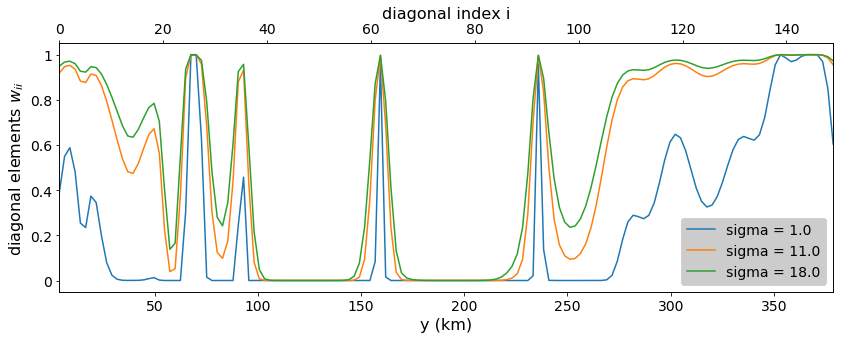

In [30]:
plt.close('all')
fig, ax1 = plt.subplots(figsize=(12,5))
ax2 = ax1.twiny()
ax2.plot(np.arange(0,n-1), np.diag(W_sgm), linestyle='None')
#ax1.plot(0.001*yc[1:n], np.diag(W_sgm))
ax1.plot(0.001*yc[1:n], np.diag(W_sgm1), label = 'sigma = 1.0')
ax1.plot(0.001*yc[1:n], np.diag(W_sgm11), label = 'sigma = 11.0')
ax1.plot(0.001*yc[1:n], np.diag(W_sgm18), label = 'sigma = 18.0')
ax1.set_xlim(0.001*yc[1], 0.001*yc[n-1])
ax2.set_xlim(0, n)
ax1.set_ylabel(r'diagonal elements $w_{ii}$', fontsize=16)
ax1.set_xlabel('y (km)', fontsize=16)
ax2.set_xlabel(r'diagonal index i', fontsize=16)
ax1.set_xticklabels(['%g'% (l) for l in ax1.get_xticks()], fontsize=14)
ax2.set_xticklabels(['%g'% (l) for l in ax2.get_xticks()], fontsize=14)
ax1.set_yticklabels(['%g'% (l) for l in ax1.get_yticks()], fontsize=14)
ax1.legend(loc='best', fontsize=14, facecolor='silver')
plt.tight_layout()
#mpl.savefig('../manuscript/figures/B-model-rifted-margin-w-diag-sgms.png', dpi='figure', bbox_inches='tight')
plt.show()

In [ ]:
g0 = g.copy()
gama = gama_list[len(gama_list)-1]
gama_list = [gama]
k2=0

for it in range(itmaxw):
    
    p1 = p.copy()
    g1 = g.copy()
    gama1 = gama.copy()
    W1 = fc.W_matrix_function(sgm,gsyn,g1)
    Hess_psi0 = 2*C.T.dot(R.T.dot(W1.T.dot(W1.dot(R.dot(C)))))

    k0=0
    k1=0    
#implementacao da funcao
    for it in range (itmax):

        p1_hat = - np.log((pjmax - p1)/(p1-pjmin))
        G1 = fc.G_matrix_function(xmax,xmin,dy,edge,dp1,dp2,S0,dw,ds,dm,dcc,dc,tw,p1,yc,ts0,two_layers=True)
    
        grad_phi = (-2/n)*G1.T.dot(gsyn - g1)
        Hess_phi = (2/n)*G1.T.dot(G1)
        
        grad_psi0 = fc.grad_psi_iso_function(S0,tw,p1,W1,R,C,D,ts0,two_layers=True)
        grad_psi1 = fc.grad_psi_tk1_function(p1,Sa)
        grad_psi2 = fc.grad_psi_tk1_function(p1,Sb)
        grad_psi3 = fc.grad_psi_eq_function(p1,rs,A)
        grad_psi4 = fc.grad_psi_eq_function(p1,rm,B)

    
        grad_gama = grad_phi + lamb*(alpha0*grad_psi0+alpha1*grad_psi1+alpha2*grad_psi2+alpha3*grad_psi3+alpha4*grad_psi4)
        Hess_gama = Hess_phi+lamb*(alpha0*Hess_psi0+alpha1*Hess_psi1+alpha2*Hess_psi2+alpha3*Hess_psi3+alpha4*Hess_psi4)
    
        T = fc.T_matrix_function(pjmin, pjmax, p1)
        
        for it_marq in range(itmax_marq):
            
            deltap = np.linalg.solve((Hess_gama.dot(T) + mi*I), -grad_gama)
            p2_hat = p1_hat + deltap
            p2 = pjmin + ((pjmax - pjmin)/(1 + np.exp(-p2_hat)))

            #Calculo do vetor de dados preditos e da funcao phi
            prism_s = fc.prism_s_function(xmax,xmin,dy,edge,ds,dcc,tw,p2,yc,ts0,two_layers=True)
            prism_c = fc.prism_c_function(xmax,xmin,dy,edge,S0,dcc,dc,tw,p2,yc,ts0,two_layers=True)
            prism_m = fc.prism_m_function(xmax,xmin,dy,edge,S0,dcc,dm,p2,yc)
        
            g2 = np.reshape(fc.g_function(np.reshape(x,(n,)),np.reshape(yc,(n,)),np.reshape(z,(n,)),gzw,prism_s,prism_c,prism_m),(n,1))
            
            gama2 = fc.gama_function(alpha0,alpha1,alpha2,alpha3,alpha4,lamb,S0,tw,gsyn,g2,p2,rs,rm,W1,R,C,D,Sa,Sb,A,B,ts0,two_layers=True)

            #Verificando se a funcao phi esta diminuindo
            k0=0
            dgama = gama2 - gama1
            if dgama > 0.:
                mi *= dmi
                print 'k0=',k0
                k0 += 1
            
            else:
                mi /= dmi
                break
              
        p1 = p2.copy()
        g1 = g2.copy()
    
        #Testando convergencia da funcao phi
        if (dgama < 0.) & (abs(gama1 - gama2) < beta):
        #if fc.convergence_function(gama1, gama2, beta):
            print '1st convergence achieved'
            break
        
        #Atualizando variaveis
        else:
            print 'k1=',k1
            k1 += 1       
        
        gama1 = gama2.copy()
        gama_list.append(gama1)
        print 'gama2 1st = ', gama1

        thicknesses = tw + ts0 + p2[0:n] + p2[n:n+n]
        assert np.alltrue(thicknesses <= S0), 'sum of the thicknesses shall be less than or equal to isostatic compensation surface'

    p = p2.copy()
    g = g2.copy()
        
    #Testando convergencia da diag de W
    print 'gama=', gama, 'e', 'gama2=', gama2
#    if (gama > gama2 ) & (abs(gama - gama2) < beta*(10**3)):
    if (gama > gama2 ):
        print '2nd convergence achieved'
        break
    else:
        k2 += 1
        print 'k2=',k2
        print 'gama 2nd = ', gama2
        
    gama = gama2.copy()
    gama_list.append(gama)
    


In [ ]:
it = [i for i in range(len(gama_list))]
#plt.figure(figsize=(8,8))
ax = plt.figure(figsize=(8,8)).gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.plot(gama_list,'ko')
plt.yscale('log')
plt.xlabel('$k$', fontsize=18)
plt.ylabel('$\Gamma(\mathbf{p})$', fontsize=18)
plt.grid()
#plt.xlim(-1,50)
#plt.xlim(-1, len(gama_list)+5)
plt.ylim(np.min(gama_list)-3*np.min(gama_list),np.max(gama_list)+3*np.min(gama_list))
#mpl.savefig('../manuscript/figures/B-model-rifted-margin-gama-list-alphas_3_1_2_1_2-sgm_01.png', dpi='figure', bbox_inches='tight')
#mpl.savefig('../manuscript/figures/B-model-rifted-margin-gama-list-alphas_2_1_2_1_2-sgm_5_more-known-depths.png', dpi='figure', bbox_inches='tight')
plt.show()

## Lithostatic Stress

In [ ]:
sgm_true = 9.81*(10**(-6))*(dw*tw + ds0*ts0 + ds1*true_ts1 + dc*(S0-tw-ts0-true_ts1-true_tm)+dm*true_tm)

sgm = 9.81*(10**(-6))*(dw*tw + ds0*ts0 + ds1*p[0:n] + dc*(S0-tw-ts0-p[0:n]-p[n:n+n])+dm*p[n:n+n])

## Inversion model plot

In [ ]:
# Inverrsion results
RM = S0 + p[n+n]
basement = tw + ts0 + p[0:n]
moho = S0 - p[n:n+n]

In [ ]:
print ptrue[n+n], p[n+n]

In [ ]:
polygons_water = []
for (yi, twi) in zip(yc, tw):
    y1 = yi - 0.5*dy
    y2 = yi + 0.5*dy

    polygons_water.append(Polygon(np.array([[y1, y2, y2, y1], 
                                            [0.0, 0.0, twi, twi]]).T,
                                               props={'density': dw - dcc}))
polygons_sediments0 = []
for (yi, twi, s0i) in zip(yc, np.reshape(tw,(n,)), np.reshape(tos,(n,))):
    y1 = yi - 0.5*dy
    y2 = yi + 0.5*dy

    polygons_sediments0.append(Polygon(np.array([[y1, y2, y2, y1], 
                                                [twi, twi, s0i, s0i]]).T,
                                                    props={'density': ds0 - dcc}))
    
polygons_sediments1 = []
for (yi, s0i, s1i) in zip(yc, np.reshape(tos,(n,)), np.reshape(basement,(n,))):
    y1 = yi - 0.5*dy
    y2 = yi + 0.5*dy

    polygons_sediments1.append(Polygon(np.array([[y1, y2, y2, y1], 
                                                [s0i, s0i, s1i, s1i]]).T,
                                                   props={'density': ds1 - dcc}))
    
polygons_crust = []
for (yi, si, Si, dci) in zip(yc, np.reshape(basement,(n,)), np.reshape(moho,(n,)), dc):
    y1 = yi - 0.5*dy
    y2 = yi + 0.5*dy

    polygons_crust.append(Polygon(np.array([[y1, y2, y2, y1], 
                                            [si, si, Si, Si]]).T,
                                                props={'density': dci - dcc})) 

polygons_mantle = []
for (yi, Si) in zip(yc, np.reshape(moho,(n,))):
    y1 = yi - 0.5*dy
    y2 = yi + 0.5*dy

    polygons_mantle.append(Polygon(np.array([[y1, y2, y2, y1], 
                                                [Si, Si, S0+p[n+n], S0+p[n+n]]]).T,
                                                    props={'density': dm - dcc}))

In [ ]:
%matplotlib inline
plt.close('all')
fig = plt.figure(figsize=(12,16))

import matplotlib.gridspec as gridspec
heights = [8, 8, 8, 1]
gs = gridspec.GridSpec(4, 1, height_ratios=heights)
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])
ax4 = plt.subplot(gs[3])

ax1.axhline(y=0.0, xmin=ymin, xmax=ymax, color='k', linestyle='--', linewidth=1)
ax1.plot(0.001*yc, gsyn, 'or', mfc='none', markersize=8, label='simulated data')
ax1.plot(0.001*yc, g0, '-b', linewidth=2, label='initial guess data')
ax1.plot(0.001*yc, g, '-g', linewidth=2, label='predicted data')
ax1.set_xlim(0.001*ymin, 0.001*ymax)
ax1.set_ylabel('gravity disturbance (mGal)', fontsize=16)
ax1.set_xticklabels(['%g'% (l) for l in ax1.get_xticks()], fontsize=14)
ax1.set_yticklabels(['%g'% (l) for l in ax1.get_yticks()], fontsize=14)
ax1.legend(loc='best', fontsize=14, facecolor='silver')

ax2.plot(0.001*yc, sgm_true, 'or', mfc='none', markersize=8, label='simulated lithostatic stress')
ax2.plot(0.001*yc, sgm, '-g', linewidth=2, label='predicted lithostatic stress')
ax2.set_xlim(0.001*ymin, 0.001*ymax)
ax2.set_ylim(1290,1380)
ax2.set_ylabel('lithostatic stress (MPa)', fontsize=16)
ax2.set_xticklabels(['%g'% (l) for l in ax2.get_xticks()], fontsize=14)
ax2.set_yticklabels(['%g'% (l) for l in ax2.get_yticks()], fontsize=14)
ax2.legend(loc='best', fontsize=14, facecolor='silver')

ax3.axhline(y=0.0, xmin=ymin, xmax=ymax, color='k', linestyle='-', linewidth=1)
aux = yc <= COT
for (pwi) in (polygons_water):
    tmpx = [x for x in pwi.x]
    tmpx.append(pwi.x[0])
    tmpy = [y for y in pwi.y]
    tmpy.append(pwi.y[0])
    ax3.plot(tmpx, tmpy, linestyle='None')
    ax3.fill(tmpx, tmpy, color='lightskyblue')
for (ps0i) in (polygons_sediments0):
    tmpx = [x for x in ps0i.x]
    tmpx.append(ps0i.x[0])
    tmpy = [y for y in ps0i.y]
    tmpy.append(ps0i.y[0])
    ax3.plot(tmpx, tmpy, linestyle='None')
    ax3.fill(tmpx, tmpy, color='tan')
for (ps1i) in (polygons_sediments1):
    tmpx = [x for x in ps1i.x]
    tmpx.append(ps1i.x[0])
    tmpy = [y for y in ps1i.y]
    tmpy.append(ps1i.y[0])
    ax3.plot(tmpx, tmpy, linestyle='None')
    ax3.fill(tmpx, tmpy, color='tan')
for (pci) in (polygons_crust[:len(yc[aux])]):
    tmpx = [x for x in pci.x]
    tmpx.append(pci.x[0])
    tmpy = [y for y in pci.y]
    tmpy.append(pci.y[0])
    ax3.plot(tmpx, tmpy, linestyle='None')
    ax3.fill(tmpx, tmpy, color='orange')
for (pcoi) in (polygons_crust[len(yc[aux]):n]):
    tmpx = [x for x in pcoi.x]
    tmpx.append(pcoi.x[0])
    tmpy = [y for y in pcoi.y]
    tmpy.append(pcoi.y[0])
    ax3.plot(tmpx, tmpy, linestyle='None')
    ax3.fill(tmpx, tmpy, color='olive')
for (pmi) in (polygons_mantle):
    tmpx = [x for x in pmi.x]
    tmpx.append(pmi.x[0])
    tmpy = [y for y in pmi.y]
    tmpy.append(pmi.y[0])
    ax3.plot(tmpx, tmpy, linestyle='None')
    ax3.fill(tmpx, tmpy, color='pink')

#ax3.axhline(y=S0, xmin=ymin, xmax=ymax, color='w', linestyle='--', linewidth=3)
ax3.plot(yc, tw, '-k', linewidth=3)
#ax3.plot(yc, tos, '-k', linewidth=3)
ax3.plot(yc, true_basement, '-k', linewidth=3, label='true surfaces')
ax3.plot(yc, true_moho, '-k', linewidth=3)
ax3.plot(yc, ini_basement, '-.b', linewidth=3, label='initial guess surfaces')
ax3.plot(yc, ini_moho, '-.b', linewidth=3)
ax3.plot(yc, basement, '--w', linewidth=3, label='estimated surfaces')
ax3.plot(yc, moho, '--w', linewidth=3)
ax3.axhline(y=true_S0+true_dS0, xmin=ymin, xmax=ymax, color='k', linestyle='-', linewidth=3)
ax3.axhline(y=S0+ini_dS0, xmin=ymin, xmax=ymax, color='b', linestyle='-.', linewidth=3)
ax3.axhline(y=S0+p[n+n], xmin=ymin, xmax=ymax, color='w', linestyle='--', linewidth=3)
ax3.plot(base_known[:,0], base_known[:,1], 'v', color = 'yellow', markersize=15, label='known depths (basement)')
#ax3.plot(base_known_old[:,0], base_known_old[:,1], 'v', color = 'yellow', markersize=15, label='known depths (basement)')
#ax3.plot(base_known_new[:,0], base_known_new[:,1], 'v', color = 'magenta', markersize=15, label='more known depths (basement)')
ax3.plot(moho_known[:,0], moho_known[:,1], 'D', color = 'lime', markersize=15, label='known depths (moho)')
#ax3.set_ylim((S0+p[n+n]), zmin)
ax3.set_ylim((57500.0), zmin)
ax3.set_xlim(ymin, ymax)
ax3.set_xlabel('y (km)', fontsize=16)
ax3.set_ylabel('z (km)', fontsize=16)
ax3.set_xticklabels(['%g'% (0.001*l) for l in ax3.get_xticks()], fontsize=14)
ax3.set_yticklabels(['%g'% (0.001*l) for l in ax3.get_yticks()], fontsize=14)
ax3.legend(loc='lower right', fontsize=14, facecolor='silver')    

X, Y = fig.get_dpi()*fig.get_size_inches()
plt.title('Density contrast (kg/m$^{3}$)', fontsize=17)
#plt.title('Density (kg/m$^{3}$)', fontsize=17)
ax4.axis('off')

layers_list1 = ['water', 'sediment', 'continental', 'oceanic', 'mantle']
layers_list2 = ['', '', 'crust', 'crust', '']
colors_list = ['lightskyblue', 'tan', 'orange', 'olive', 'pink']
density_list = ['-1820', '-250', '0', '35', '400'] #original
#density_list = ['1030', '2600', '2850', '2885', '3250']
ncols = len(colors_list)
nrows = 1
h = Y / nrows
w = X / (ncols + 1)

i=ncols-1
for color, density, layers1, layers2 in zip(colors_list, density_list, layers_list1, layers_list2):
    col = i // nrows
    row = i % nrows
    x = X - (col*w) - w
    
    yi_line = Y
    yf_line = Y - Y*0.15
    yi_text1 = Y - Y*0.2
    yi_text2 = Y - Y*0.28
    yi_text3 = Y - Y*0.08
    
    i-=1
    poly = Polygon(np.array([[x, x+w*0.75, x+w*0.75, x], [yi_line, yi_line, yf_line, yf_line]]).T)
    tmpx = [x for x in poly.x]
    tmpx.append(poly.x[0])
    tmpy = [y for y in poly.y]
    tmpy.append(poly.y[0])
    ax4.plot(tmpx, tmpy, linestyle='-', color='k', linewidth=1)
    ax4.fill(tmpx, tmpy, color=color)
    ax4.text(x+w*0.375, yi_text1, layers1, fontsize=(w*0.14), horizontalalignment='center', verticalalignment='top')
    ax4.text(x+w*0.375, yi_text2, layers2, fontsize=(w*0.14), horizontalalignment='center', verticalalignment='top')
    ax4.text(x+w*0.375, yi_text3, density, color = 'k', fontsize=(w*0.14), horizontalalignment='center', verticalalignment='center')

plt.tight_layout()
#mpl.savefig('../manuscript/figures/B-model-rifted-margin-grafics-estimated-model-alphas_3_1_2_1_2-sgm_01.png', dpi='figure', bbox_inches='tight')    
#mpl.savefig('../manuscript/figures/B-model-rifted-margin-grafics-estimated-model-alphas_2_1_2_1_2-sgm_5_more-known-depths.png', dpi='figure', bbox_inches='tight')

plt.show()      